# topics

* perceptron
    * own version is a full-fledged perceptron
    * compared to sklearn version: performs equal
    * applied to real example: animacy detection
* further clarifications on the basis of a toy example: authorship detection
    * project 3-dim to 2-dim
* one-hot encoding 
* data (representation) not suited for perceptron

## Absorb b

* assume $w=(0.2,0.9)$ and $b=2$
* we set $w_0$= $b$, i.e. $w=(2,0.2,0.9)$ and set every $x_0$ of all feature vectors $x^{(i)}$ to 1 
* e.g. $x^{(1)}=(4,2)$
* then we use $x^{(1)}=(1,4,2)$
* since $(0.2,0.9) \cdot (4,2) + 2 = (2,0.2,0.9) \cdot (1,4,2) $

**note: we can absorb it into any dimension, the first one, the last one, whatever**

In [1]:
import numpy as np

w=[0.2,0.9]
b=2
x=[4,2]

np.dot(w,x)+b, np.sign(np.dot(w,x)+b)

(4.6, 1.0)

In [2]:
w=[2,0.2,0.9]
x=[1,4,2]

np.dot(w,x),np.sign(np.dot(w,x))

(4.6, 1.0)

## How we do it here

* we absorb it into dimension 0
* the weight vector has dimension + 1 (initialisation)
* we use np.append(1,x) to add 1 at $x_0$

## Animacy classification with FastText embeddings

* given noun denoting animate and inanimate objects
* map each word to its embedding (300 dimension = features)
* learn a binary classifier


In [3]:
# load FastText embeddings: it takes a few seconds

from sklearn.model_selection import train_test_split
import numpy as np

#from numpy import mean
from sklearn.model_selection import cross_val_score

FastTextPath="/home/klenner/Lehre/ml20/cc.de.300.bin"    

import fasttext
model = fasttext.load_model(FastTextPath)

In [4]:
# load training data for animacy classifier

X,y=[],[]

rootdir="/home/klenner/actor_V3/"

def loadac(file,label):
    file=rootdir+file
    with open(file,"r") as f:
        for line in f:
            w=line.strip("\n")
            w=model.get_word_vector(w)   # map word to embedding
            X.append(w)
            y.append(label)
            
loadac("gold_actorV3",1)
loadac("gold_nonactor",0)

## sklearn perceptron

In [5]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

clf = Perceptron(max_iter=1000,alpha=0,fit_intercept=True)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

w_perc=clf.coef_[0]
b=clf.intercept_

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1474
           1       0.96      0.95      0.96      1854

    accuracy                           0.95      3328
   macro avg       0.95      0.95      0.95      3328
weighted avg       0.95      0.95      0.95      3328



In [6]:
w_perc,b

(array([ 5.95762906e-01,  1.27116010e+00,  1.01569144e+00, -3.90144799e-01,
        -3.75048405e-01,  9.36305153e-01,  2.53789443e-01, -1.47106948e+00,
         1.18794026e+00,  1.47847376e+00,  3.66728734e+00,  5.53003977e-01,
        -1.77496582e+00,  1.53738066e+00,  8.56575641e-01,  2.10233503e+00,
        -3.41230761e+00, -2.16934808e+00, -6.43137907e-01,  5.82393205e+00,
        -6.00189381e-01, -1.85836425e+00, -1.88974498e+00,  3.68283221e+00,
        -5.83811984e-01, -1.20460790e+00,  1.90815544e+00,  2.04845261e-01,
        -2.61899147e+00,  1.78744959e-01, -1.34135657e+00, -3.12208727e-01,
        -8.92723358e-01,  5.48834101e+00, -4.52380735e-01,  1.44914788e+00,
         1.63314335e+00,  2.28864818e-01,  1.47746242e+00, -1.50811230e+00,
         2.57119487e-01, -1.20330578e+00,  3.41709444e+00, -1.72723901e+00,
        -3.73527650e+00,  2.05667262e+00, -1.51019603e+00,  3.61978989e-01,
        -5.93578958e-01,  7.60334948e-01,  2.08523369e+00, -2.81975422e-02,
         5.7

In [7]:
clf.loss_function_

## Own perceptron

* it takes longer, uses a different loss function, no regularization used
* performance is identical, anyway
* 1st derivative of loss function, here called $Jd$ (like in the code below): vectors in ${\bf bold}$
$$Jd(w_j)=-\frac{1}{n}(\sum_i^n (y^{(i)}-{\bf w}\cdot {\bf x}^{(i)})x_j^{(i)})$$
* in the implementation below instead of a loop over all $w_j$ and all $x_j$ numpy's vector muliplication is used to do it in a single step
* since embedding values are small, we skip normalization
  $$Jd(w_j)=-\sum_i^n (y^{(i)}-{\bf w}\cdot {\bf x}^{(i)})x_j^{(i)}$$
* equivalent formula (some textbooks use it):
  $$Jd(w_j)=\sum_i^n ({\bf w}\cdot {\bf x}^{(i)}-y^{(i)})x_j^{(i)}$$

## A closer look into jd

* a scalar: (truelabel-step(np.dot(w,np.append(1,x))))
* all x-values including 1 for the bias: np.append(1,x)
* the scalar muliplied with x-value array: multiply each dimension with the scalar
* the sum then is done on a all x-vectors from the data, adding the dimensions
* the return value then is the gradient, i.e. a vector with all partial derivatives
* in the delta rule, $w$ is the weight **vector**, adding (substracting) two vectors just again is done dimension wise
* we're updating the whole weight vector dimension-wise


In [ ]:
a=np.array([1,2,3])
a+a,a-a,3*a

## A full-flegded perceptron in 20 lines

In [9]:
step=lambda x: 0 if x <=0.5 else 1

np.random.seed(0)
w=np.random.rand(1,301)[0]                   
eta=0.01

def jd(w,X,y):  # 1st derivative of J
    #return -sum([(truelabel-step(np.dot(w,np.append(1,x))))*np.append(1,x) for x,truelabel in zip(X,y)]) # OR equivalent
    return (sum([(step(np.dot(w,np.append(1,x)))-truelabel)*np.append(1,x) for x,truelabel in zip(X,y)]))

def learn(epochs,eta,w,X_train,y_train):
    for _ in range(epochs):
        w= w + (-eta * jd(w,X_train,y_train))
    return w
    
def predict(w,X_test):
    return [step(np.dot(w,np.append(1,x))) for x in X_test]
   
w=learn(100,eta,w,X_train,y_train)
y_pred=predict(w,X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1501
           1       0.95      0.95      0.95      1827

    accuracy                           0.95      3328
   macro avg       0.95      0.95      0.95      3328
weighted avg       0.95      0.95      0.95      3328



In [10]:
# predict the label of a single word

def word_predict(w,word):
    e=model.get_word_vector(word)   
    return step(np.dot(w,np.append(1,e)))

word_predict(w,'Minister'),word_predict(w,'Kuchen')

(1, 0)

## Authorship detection (toy example)

* authorship detection (extremely simplified)
* two features: phrase length, adjective frequency
* only two authors
* train/test split: stratify, i.e. preserve the distribution


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1 = np.linspace(0,10)
x2 = np.linspace(0,20)
X1,X2= np.meshgrid(x1,x2)
        
def hplot():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u,v=-1,-1
    for l,k in zip(y,X):     
        if l==0:
            ax.scatter(k[0],k[1],l,c='r',marker='o')
        else:   
            ax.scatter(k[0],k[1],l,c='b',marker='o')
            
    ax.set_xlabel('phrase length')
    ax.set_ylabel('adjective frequency')
    ax.set_zlabel('Class')

## Linear separability revisited

* we cannot determine separability on the basis of the (full) gold data plot
* **full** means: including the labels
* linear separable if we can find a function that for all instances of label 0 assign a value of $\leq 0.5$ and for all label 1 instances a value of $>0.5$
* we have to look into the feature space


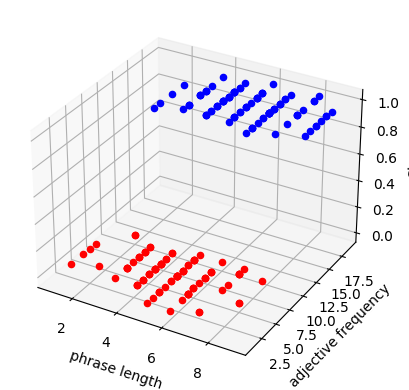

In [12]:
import pickle
import numpy as np
f=open("autor2f","rb")
X,y=pickle.load(f)
X=np.array(X)

hplot()

## Plot in the feature space

* y=10.5 would be an almost perfect classifier
  
**note** we can't this visualize normally since we never use have only 2 or 3 feature dimension

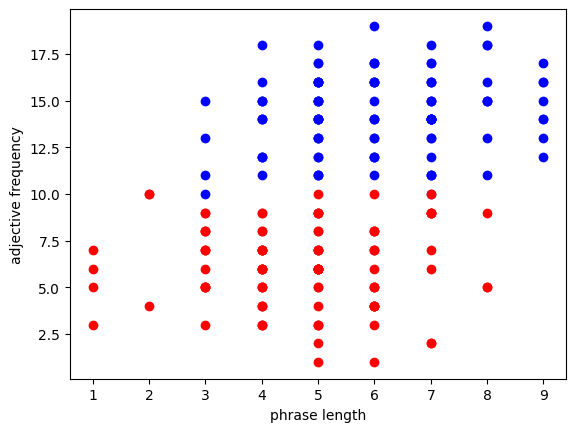

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for l,k in zip(y,X):
    if l==0:
        plt.plot(k[0],k[1],'ro')   
    else:
        plt.plot(k[0],k[1],'bo')  
        
plt.xlabel('phrase length')
plt.ylabel('adjective frequency')

plt.show()

In [14]:
# how the data looks like

X[:2],y[:2]

(array([[ 6, 16],
        [ 7, 13]]),
 [1, 1])

## Feature plot


* data is linear separable
* this time, a bias term was needed

## Our perceptron

* let's apply it
* performance not that good
* problem: feature dimensions have different value ranges
     * values are high
     * dot product will produce high guesses then
     * gradient descent might be a problem

In [15]:
np.random.seed(0)
w=np.random.rand(1,3)[0]                   
eta=0.01

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)

w=learn(1000,eta,w,X_train,y_train)
y_pred=predict(w,X_test)
 
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.96      1.00      0.98        24

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [16]:
w

array([-51.5911865 ,  -0.37481063,   5.05276338])

**what about sklearn, the professional perceptron implementation?**

## Sklearn perceptron

* it doesn't work without a bias term (intercept)


In [17]:
from sklearn.linear_model import Perceptron

clf = Perceptron(max_iter=1000,alpha=0,fit_intercept=False)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      0.61      0.73        38
           1       0.40      0.83      0.54        12

    accuracy                           0.66        50
   macro avg       0.66      0.72      0.64        50
weighted avg       0.80      0.66      0.68        50



In [18]:
clf = Perceptron(max_iter=1000,alpha=0,fit_intercept=True)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

w=clf.coef_[0]
b=clf.intercept_

print(classification_report(y_pred, y_test)) 

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        28
           1       0.88      1.00      0.94        22

    accuracy                           0.94        50
   macro avg       0.94      0.95      0.94        50
weighted avg       0.95      0.94      0.94        50



In [19]:
w,b

(array([-14.,  21.]), array([-161.]))

## Can we visualise the hyperplane in class space?


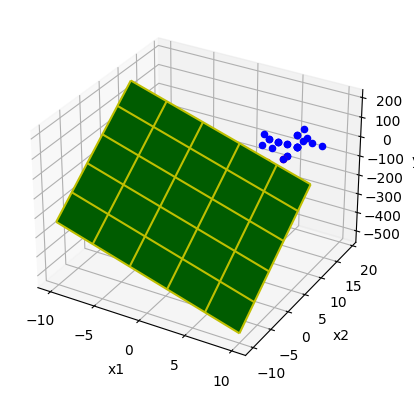

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1 = np.linspace(-10,10)
x2 = np.linspace(-10,10)
X1,X2= np.meshgrid(x1,x2)
        
def hplot(w,plane,dense):

  #  Y=(w[1]*X1+w[2]*X2)+w[0]
    Y=((w[0]*X1+w[1]*X2)+b[0])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for l,k in zip(y_test,X_test): 
        if l==0:
            ax.scatter(k[0],k[1],l,c='r',marker='o')
        else:   
            ax.scatter(k[0],k[1],l,c='b',marker='o')
    if plane and dense:   # show the hyperplane
        ax.plot_surface(X1, X2, Y, rstride=10, cstride=10,color='g')
    ax.plot_wireframe(X1, X2, Y, rstride=10, cstride=10,color='y')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    
hplot(w,1,1)

## What about a plot in feature space?

In [22]:
w,b

(array([-14.,  21.]), array([-161.]))

## Projected down from class space to feature space


* our hyperplane $f(x_1,x_2)=w_1*x_1+w_2*x2+b$ in 3-dim space
* project onto 2 dimensions (the feature dimension)
* we resolve $w_1*x_1+w_2*x2+b = 0$ for $x_2$
* ..
* $y=x_2=-\frac{w_1}{w_2}x_1-\frac{b}{w_2}$


In [23]:
print("f(x2)=",-w[0]/w[1],"*x1 +",-b[0]/w[1])

f(x2)= 0.6666666666666666 *x1 + 7.666666666666667


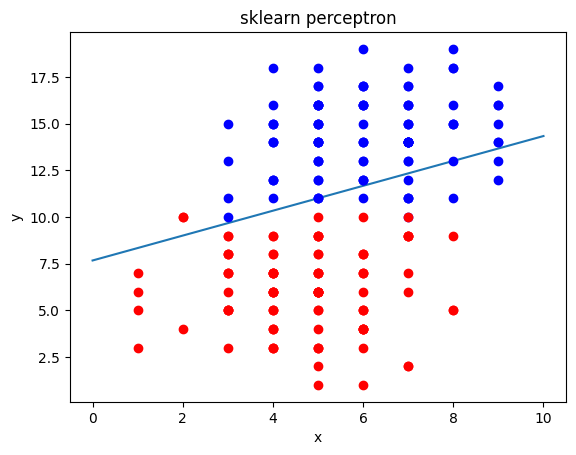

In [24]:
def fct(x1):
    return -w[0]/w[1]*x1-b[0]/w[1]   #  0.015384615384615417 *x1 + 0.5538461538461543

def myplot():
    px=[0,0.5]
    py=[fct(0),fct(0.5)]
    px=[0,10]
    py=[fct(0),fct(10)]

    plt.plot(px,py)

    for l,k in zip(y,X):
        if l==1:
            plt.plot(k[0],k[1],'bo')   
        else:
            plt.plot(k[0],k[1],'ro')  
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('sklearn perceptron')
    plt.show()

myplot()

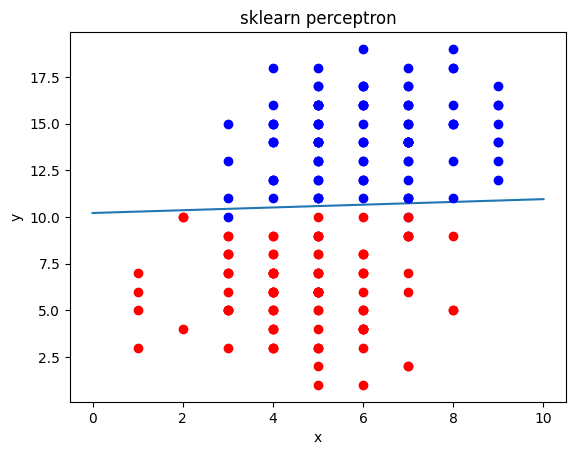

In [25]:
np.random.seed(0)
w=np.random.rand(1,3)[0]             
w=learn(1000,eta,w,X_train,y_train)
w,b=w[1:],[w[0]]
myplot()

## Visualize misclassifications

* apply sklearn perceptron again
* show the cases it misclassifies
    * if 0 is predicted, but 1 is the label, the wrong color is assigned

In [26]:
clf = Perceptron(max_iter=1000,alpha=0,fit_intercept=True)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

w=clf.coef_[0]
b=clf.intercept_

#print(classification_report(y_pred, y_test)) 

this is the result over the test data


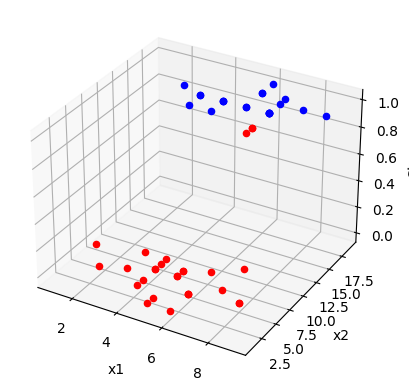

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x1 = np.linspace(0.0,0.1)
x2 = np.linspace(-0.1,0.1)

X1,X2= np.meshgrid(x1,x2)

def misclassify(w):
    Y=w[0]*X1+w[1]*X2+b
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for l,k in zip(y_test,X_test):   
        e=step(np.dot(w,k)+b)   # our prediction
        if e==0:                # l is 0 or 1, if 1 then false (red point at 1)
            ax.scatter(k[0],k[1],l,c='r',marker='o')
        else:  
            ax.scatter(k[0],k[1],l,c='b',marker='o')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Class')
 
print("this is the result over the test data")
misclassify(w)

In [28]:
X_test[:10]

array([[ 6, 17],
       [ 5,  2],
       [ 6, 17],
       [ 5,  6],
       [ 7, 14],
       [ 5, 14],
       [ 4, 14],
       [ 5, 14],
       [ 4, 14],
       [ 6,  4]])

In [ ]:
sum(y_pred==y_test)/len(y_test)

# Data not suited for perceptron

**PoS tagger bad performance**

* your PoS tagger is bad at the distinction between articles and relative pronouns

### input data
    * 1000 examples of pos (part of speech sequences)
    * format: pos1,pos2,der|die|das,pos3,pos4, art|prels
    * last dimension is the class: art or prels
   
### examples
* VVFIN,ADV,die,NN,VVFIN, art
* CARD,NN,die,NN,VVFIN, art
* NE,komma,die,APPR,NN, prels

* **note** A comma is not a perfect indicator of prels; e.g. "das Kind, das Pferd und das Haus"
* **note** Neither indicates a noun immediatly following "der,die,das" an article: see "die Frau, die Bilder malt"

### coding

* turn "VVFIN,ADV,die,NN,VVFIN" into e.g. "0,1,10,14,0"
    * using integers is not in any case a good idea
* latter we use one-hot encoding

In [80]:
import numpy as np   
from sklearn.utils import shuffle

examples,vocab,X_data,y=[],[],[],[]

f=open("sv.data","r")

# first get the tag vocabulary and the labels y
for i in f:
    i=i.strip("\n").split(",")
    tags=i[:-1]
    (_,A,_,B,C)=tags
    tags=[A,B]
    if tags in examples:   # remove redundant sequences
        continue
    examples.append(tags)
    vocab=vocab+tags
    y.append(int(i[-1] ==' art'))  # gives 1 if true 0 otherwise
f.close()

vocab=(list(set(vocab))) # remove redundant tags by set() mapping

#vocab=shuffle(vocab, random_state=10)   # we randomly induce distances between points

# second: index pos with vocab list
for seq in examples:   # e.g seq=NN,APPR,die,NE,NE
    S=[vocab.index(tag) for tag in seq] # a tag is mapped to its index in the vocab array
    X_data.append(S)        # e.g. S=[40, 0, 37, 17, 17]

vocab_len=len(vocab)
vocab.sort()

X_data=np.array(X_data)

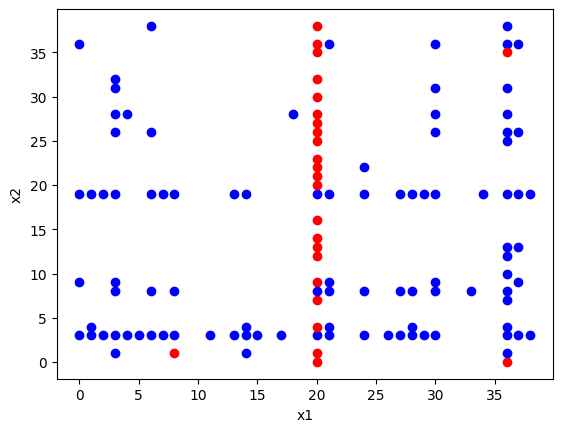

In [54]:
for l,k in zip(y,X_data):
    if l==1:
        plt.plot(k[0],k[1],'bo')   
    else:
        plt.plot(k[0],k[1],'ro')  
        
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

In [55]:
from sklearn.linear_model import Perceptron

X_train, X_test, y_train, y_test = train_test_split(X_data, y, stratify=y,random_state=0)

clf = Perceptron(max_iter=600,alpha=0,fit_intercept=True)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

w=clf.coef_[0]
b=clf.intercept_

print(classification_report(y_pred, y_test)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.89        31

    accuracy                           0.81        31
   macro avg       0.50      0.40      0.45        31
weighted avg       1.00      0.81      0.89        31



/home/klenner/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/klenner/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/klenner/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
from sklearn.metrics import precision_score

precision_score(y_test, y_pred)

0.8064516129032258

In [57]:
one=len([1 for a,b in zip(y_test,y_pred) if a==1 and a==b])
zero=len([1 for a,b in zip(y_test,y_pred) if a==0 and a==b])

(one+zero)/len(y_pred)

0.8064516129032258

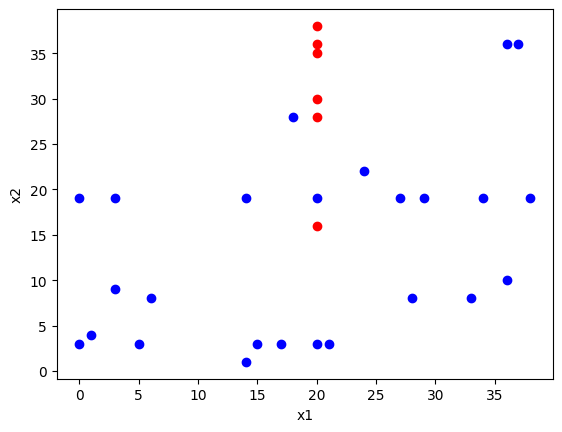

In [58]:
# plot for the test data

for l,k in zip(y_test,X_test):
    if l==1:
        plt.plot(k[0],k[1],'bo')   
    else:
        plt.plot(k[0],k[1],'ro')  
        
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

In [59]:
# determine the function in 2-dim

w=clf.coef_[0]
b=clf.intercept_

print("f(x2)=",-w[0]/w[1],"*x1 +",-b[0]/w[1])

f(x2)= -6.5 *x1 + -5.5


In [51]:
w,b

(array([-27.,   3.]), array([-7.]))

## Plot of the hyperplane in 2-dim

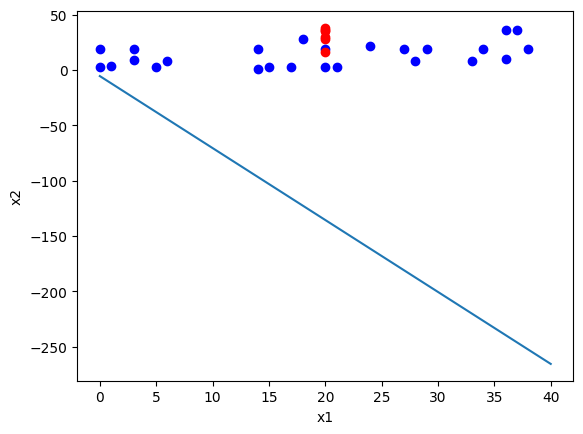

In [60]:
def fct(x1):
    return -w[0]/w[1]*x1 -b[0]/w[1]
    
px=[0,40]
py=[fct(0),fct(40)]
plt.plot(px,py)

for l,k in zip(y_test,X_test):
    if l==1:
        plt.plot(k[0],k[1],'bo')   
    else:
        plt.plot(k[0],k[1],'ro')  
        
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

## i.e. everything is class 1

In [61]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [62]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
y_pred=clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_pred, y_test)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.89        31

    accuracy                           0.81        31
   macro avg       0.50      0.40      0.45        31
weighted avg       1.00      0.81      0.89        31



/home/klenner/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/klenner/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/klenner/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
# class probabilities

y_pred,np.exp(clf.class_log_prior_)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.20879121, 0.79120879]))

In [64]:
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=10)

cvs=cross_val_score(clf, X_data,y, cv=10)
cvs,sum(cvs)/len(cvs)

(array([1.        , 0.92307692, 0.91666667, 0.75      , 0.91666667,
        0.91666667, 0.75      , 1.        , 0.91666667, 0.83333333]),
 0.8923076923076924)

In [65]:
from sklearn import tree

clf.fit(X_data, y)  # in order to have a tree plot

text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_0 <= 20.50
|   |--- feature_0 <= 19.00
|   |   |--- feature_1 <= 2.00
|   |   |   |--- feature_0 <= 5.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  5.50
|   |   |   |   |--- feature_0 <= 11.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  11.00
|   |   |   |   |   |--- class: 1
|   |   |--- feature_1 >  2.00
|   |   |   |--- class: 1
|   |--- feature_0 >  19.00
|   |   |--- feature_1 <= 19.50
|   |   |   |--- feature_1 <= 17.50
|   |   |   |   |--- feature_1 <= 8.50
|   |   |   |   |   |--- feature_1 <= 7.50
|   |   |   |   |   |   |--- feature_1 <= 2.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1 >  2.00
|   |   |   |   |   |   |   |--- feature_1 <= 3.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_1 >  3.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_1 >  7.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- fe

In [66]:
X_or=[[0,1],[1,0],[1,1],[0,0]]

y=[1,1,0,0]

clf.fit(X_or, y)

print(clf.predict(X_or),"\n")

text_representation = tree.export_text(clf)
print(text_representation)

[1 1 0 0] 

|--- feature_1 <= 0.50
|   |--- feature_0 <= 0.50
|   |   |--- class: 0
|   |--- feature_0 >  0.50
|   |   |--- class: 1
|--- feature_1 >  0.50
|   |--- feature_0 <= 0.50
|   |   |--- class: 1
|   |--- feature_0 >  0.50
|   |   |--- class: 0



## Take away

* there are various learning tasks
    * classification (text)
    * sequence modelling (tagging)
    * structure modelling (parsing)
* coding categorial data with integers might be problematic depending on the learning approach
    * no problem with Naive Bayes or decision trees
    * problem for all approaches that interpret data geometrically (points in space): perceptron
        * reason: we induce arbitrary differences by random assignment of integers

## One-hot encoding

* does not induce distances
* for each feature, we get a feature size vector with at most one value set to 1, rest is 0
* we concate all feature vectors


**no distance induced since either perfect match or zero match**

example:
* 2 values: NN,PPER
* order: NN,PPER
* 2 dimensions
* if PPER is given, encoding is: "0,1"
* if NN is given, encoding is: "1,0"

In [75]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()

x=[["nsubj","NN",2],["nsubj","NN",1],["obj","PPER",9]]

ohe.fit_transform(x).toarray()

array([[1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1.]])

## Interpretation

* first entry: [1., 0., 1., 0., 0., 1., 0.]
    * 0-1: 1st feature, 2 possible values  (nsubj)
    * 2-3: 1st feature, 2 possible values  (NN)
    * 4-6: 3rd feature, 3 possible values  (2)

In [76]:
ohe.categories_

[array(['nsubj', 'obj'], dtype=object),
 array(['NN', 'PPER'], dtype=object),
 array([1, 2, 9], dtype=object)]

In [82]:
enc = OneHotEncoder()
enc.fit(X_data)

X_data=enc.transform(X_data).toarray()

In [83]:
X_data

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [84]:
clf = Perceptron(max_iter=600,alpha=0,fit_intercept=True)

X_train, X_test, y_train, y_test = train_test_split(X_data, y, stratify=y,random_state=0)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(classification_report(y_pred, y_test)) 

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.92      1.00      0.96        23

    accuracy                           0.94        31
   macro avg       0.96      0.88      0.91        31
weighted avg       0.94      0.94      0.93        31

